# 1. Libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA

from pyod.models.iforest import IForest
from pyod.models.pca import PCA

from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score

import tensorflow as tf

import seaborn as sns
sns.set_style('white')

import warnings
warnings.filterwarnings(action='ignore')

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print(tf.config.list_physical_devices('GPU'))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8837093561101089269
xla_global_id: -1
]
[]


In [3]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = '0' # 여러개 사용시 '0,1,2' 식으로 하나의 문자열에 입력
gpus = tf.config.experimental.list_physical_devices('GPU') # 호스트 러나임에 표시되는 GPU 장치 목록 반환

if gpus: # 반환된 GPU 장치 목록이 있다면
    try: # 해당 장치에 대한 메모리 증가 활성화 여부 설정
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e: # try문 실패시에 에러문구 출력
        print(e)

In [4]:
path = "./Dataset/"

dataT = pd.read_csv(path+"train_T.csv")  
dataO = pd.read_csv(path+"train_O.csv")  

# original data -> data
data = pd.concat([dataT, dataO]).reset_index(drop=True)
data

,Y_Class,Y_Quality,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,...,X_3317,X_3318,X_3319,X_3320,X_3321,X_3322,X_3323,X_3324,X_3325,X_3326
0,1,0.531957,T100304,T_31,2.0,95.0,0.0,45.0,10.0,0.0,...,0.000008,0.000003,0.191408,0.000008,0.001210,0.000021,0.000003,0.000002,0.189,0.000006
1,1,0.531105,T100306,T_31,2.0,96.0,0.0,45.0,10.0,0.0,...,0.000008,0.000003,0.188993,0.000032,0.000644,0.000041,0.000002,0.000003,0.185,0.000029
2,1,0.532292,T100306,T_31,2.0,95.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0.528141,T100306,T_31,2.0,87.0,0.0,45.0,10.0,0.0,...,0.000007,0.000003,0.189424,0.000034,0.000678,0.000043,0.000004,0.000003,0.188,0.000031
4,1,0.532289,T100306,T_31,2.0,95.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,1,0.529740,T100304,O_31,154.0,97.0,0.0,45.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
834,1,0.532343,T100306,O_31,146.0,94.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
835,1,0.530533,T100304,O_31,4.0,98.0,0.0,45.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
836,2,0.535205,T100306,O_31,6.0,89.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 2. Preprocessing

1. 같은 값으로만 채워진 column 삭제 (nunique(dropna=False) <= 1) 
2. 모든 행이 같은 값을 가지는 두 개 이상의 중복된 column 삭제 
3. 결측치 처리 (KNN Imputetor, fillna(0))
4. 정규화 (Robust, MinMax, Standard)
5. 카테고리 변수 수치화 (LINE, PRODUCT_CODE) LabelEncoder

In [163]:
# 1. Handling missing values  
# Preprocessed data -> processed_data
processed_data = data.copy()
processed_data = processed_data.fillna(0)
processed_data

,Y_Class,Y_Quality,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,...,X_3317,X_3318,X_3319,X_3320,X_3321,X_3322,X_3323,X_3324,X_3325,X_3326
0,1,0.531957,T100304,T_31,2.0,95.0,0.0,45.0,10.0,0.0,...,0.000008,0.000003,0.191408,0.000008,0.001210,0.000021,0.000003,0.000002,0.189,0.000006
1,1,0.531105,T100306,T_31,2.0,96.0,0.0,45.0,10.0,0.0,...,0.000008,0.000003,0.188993,0.000032,0.000644,0.000041,0.000002,0.000003,0.185,0.000029
2,1,0.532292,T100306,T_31,2.0,95.0,0.0,45.0,10.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
3,1,0.528141,T100306,T_31,2.0,87.0,0.0,45.0,10.0,0.0,...,0.000007,0.000003,0.189424,0.000034,0.000678,0.000043,0.000004,0.000003,0.188,0.000031
4,1,0.532289,T100306,T_31,2.0,95.0,0.0,45.0,10.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,1,0.529740,T100304,O_31,154.0,97.0,0.0,45.0,11.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
834,1,0.532343,T100306,O_31,146.0,94.0,0.0,45.0,10.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
835,1,0.530533,T100304,O_31,4.0,98.0,0.0,45.0,11.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
836,2,0.535205,T100306,O_31,6.0,89.0,0.0,45.0,10.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000


In [164]:
# 2. 같은 값으로만 채워진 column 삭제 (nunique(dropna=False) <= 1)
# Get the counts of unique values per column
value_counts = processed_data.iloc[:,4:].apply(lambda x: x.nunique(dropna=False))

# Filter columns with only one unique value
unique_columns = value_counts[value_counts >= 2].index
duplicated_columns = value_counts[value_counts <= 1].index

processed_data = processed_data.drop(duplicated_columns, axis=1)
processed_data

,Y_Class,Y_Quality,LINE,PRODUCT_CODE,X_1,X_2,X_4,X_5,X_7,X_8,...,X_3317,X_3318,X_3319,X_3320,X_3321,X_3322,X_3323,X_3324,X_3325,X_3326
0,1,0.531957,T100304,T_31,2.0,95.0,45.0,10.0,45.0,10.0,...,0.000008,0.000003,0.191408,0.000008,0.001210,0.000021,0.000003,0.000002,0.189,0.000006
1,1,0.531105,T100306,T_31,2.0,96.0,45.0,10.0,53.0,10.0,...,0.000008,0.000003,0.188993,0.000032,0.000644,0.000041,0.000002,0.000003,0.185,0.000029
2,1,0.532292,T100306,T_31,2.0,95.0,45.0,10.0,60.0,10.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
3,1,0.528141,T100306,T_31,2.0,87.0,45.0,10.0,53.0,10.0,...,0.000007,0.000003,0.189424,0.000034,0.000678,0.000043,0.000004,0.000003,0.188,0.000031
4,1,0.532289,T100306,T_31,2.0,95.0,45.0,10.0,51.0,10.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,1,0.529740,T100304,O_31,154.0,97.0,45.0,11.0,45.0,10.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
834,1,0.532343,T100306,O_31,146.0,94.0,45.0,10.0,67.0,11.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
835,1,0.530533,T100304,O_31,4.0,98.0,45.0,11.0,45.0,10.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
836,2,0.535205,T100306,O_31,6.0,89.0,45.0,10.0,51.0,10.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000


In [165]:
# 3. 모든 행이 같은 값을 가지는 두 개 이상의 중복된 column 삭제
df = processed_data.iloc[:,4:].T.drop_duplicates(keep='first').T
processed_data = pd.concat([processed_data.iloc[:,:4], df], axis=1)
processed_data

,Y_Class,Y_Quality,LINE,PRODUCT_CODE,X_1,X_2,X_4,X_5,X_7,X_8,...,X_3317,X_3318,X_3319,X_3320,X_3321,X_3322,X_3323,X_3324,X_3325,X_3326
0,1,0.531957,T100304,T_31,2.0,95.0,45.0,10.0,45.0,10.0,...,0.000008,0.000003,0.191408,0.000008,0.001210,0.000021,0.000003,0.000002,0.189,0.000006
1,1,0.531105,T100306,T_31,2.0,96.0,45.0,10.0,53.0,10.0,...,0.000008,0.000003,0.188993,0.000032,0.000644,0.000041,0.000002,0.000003,0.185,0.000029
2,1,0.532292,T100306,T_31,2.0,95.0,45.0,10.0,60.0,10.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
3,1,0.528141,T100306,T_31,2.0,87.0,45.0,10.0,53.0,10.0,...,0.000007,0.000003,0.189424,0.000034,0.000678,0.000043,0.000004,0.000003,0.188,0.000031
4,1,0.532289,T100306,T_31,2.0,95.0,45.0,10.0,51.0,10.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,1,0.529740,T100304,O_31,154.0,97.0,45.0,11.0,45.0,10.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
834,1,0.532343,T100306,O_31,146.0,94.0,45.0,10.0,67.0,11.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
835,1,0.530533,T100304,O_31,4.0,98.0,45.0,11.0,45.0,10.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
836,2,0.535205,T100306,O_31,6.0,89.0,45.0,10.0,51.0,10.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000


In [166]:
# 4. Regularization 
rs = RobustScaler()
ss = StandardScaler()

processed_data.iloc[:, 4:] = rs.fit_transform(processed_data.iloc[:, 4:])
processed_data

,Y_Class,Y_Quality,LINE,PRODUCT_CODE,X_1,X_2,X_4,X_5,X_7,X_8,...,X_3317,X_3318,X_3319,X_3320,X_3321,X_3322,X_3323,X_3324,X_3325,X_3326
0,1,0.531957,T100304,T_31,0.0,0.0,0.0,0.0,-0.833333,0.0,...,0.000008,0.000003,0.191408,0.000008,0.001210,0.000021,0.000003,0.000002,0.189,0.000006
1,1,0.531105,T100306,T_31,0.0,0.2,0.0,0.0,0.500000,0.0,...,0.000008,0.000003,0.188993,0.000032,0.000644,0.000041,0.000002,0.000003,0.185,0.000029
2,1,0.532292,T100306,T_31,0.0,0.0,0.0,0.0,1.666667,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
3,1,0.528141,T100306,T_31,0.0,-1.6,0.0,0.0,0.500000,0.0,...,0.000007,0.000003,0.189424,0.000034,0.000678,0.000043,0.000004,0.000003,0.188,0.000031
4,1,0.532289,T100306,T_31,0.0,0.0,0.0,0.0,0.166667,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,1,0.529740,T100304,O_31,152.0,0.4,0.0,1.0,-0.833333,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
834,1,0.532343,T100306,O_31,144.0,-0.2,0.0,0.0,2.833333,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
835,1,0.530533,T100304,O_31,2.0,0.6,0.0,1.0,-0.833333,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
836,2,0.535205,T100306,O_31,4.0,-1.2,0.0,0.0,0.166667,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000


In [167]:
# 5. Label Encoding 
cat_cols = ['PRODUCT_CODE', 'LINE']

for col in cat_cols:
    le = LabelEncoder()
    processed_data[col] = le.fit_transform(processed_data[col])
    print(le.classes_)

processed_data.head()

['O_31' 'T_31']
['T100304' 'T100306']


,Y_Class,Y_Quality,LINE,PRODUCT_CODE,X_1,X_2,X_4,X_5,X_7,X_8,...,X_3317,X_3318,X_3319,X_3320,X_3321,X_3322,X_3323,X_3324,X_3325,X_3326
0,1,0.531957,0,1,0.0,0.0,0.0,0.0,-0.833333,0.0,...,0.000008,0.000003,0.191408,0.000008,0.001210,0.000021,0.000003,0.000002,0.189,0.000006
1,1,0.531105,1,1,0.0,0.2,0.0,0.0,0.500000,0.0,...,0.000008,0.000003,0.188993,0.000032,0.000644,0.000041,0.000002,0.000003,0.185,0.000029
2,1,0.532292,1,1,0.0,0.0,0.0,0.0,1.666667,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
3,1,0.528141,1,1,0.0,-1.6,0.0,0.0,0.500000,0.0,...,0.000007,0.000003,0.189424,0.000034,0.000678,0.000043,0.000004,0.000003,0.188,0.000031
4,1,0.532289,1,1,0.0,0.0,0.0,0.0,0.166667,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000


In [162]:
# # 6. Multicollinearity 
# from collinearity import SelectNonCollinear

# nonX_data = processed_data.iloc[:, :3]
# X_data = processed_data.iloc[:, 3:]

# selector = SelectNonCollinear(0.9)
# selector.fit(X_data.values)
# mask = selector.get_support() # True or False

# selected_df = pd.DataFrame(X_data.loc[:,mask])
# processed_data = pd.concat([nonX_data, selected_df], axis=1)
# processed_data

,Y_Class,Y_Quality,LINE,PRODUCT_CODE,X_1,X_2,X_4,X_5,X_7,X_8,...,X_3211,X_3212,X_3215,X_3217,X_3219,X_3257,X_3260,X_3311,X_3312,X_3320
0,1,0.531957,0,1,0.0,0.0,0.0,0.0,-0.833333,0.0,...,0.000006,4.600000e-06,14715.0,484.0,0.0,515.0,166.0,0.000016,0.000004,0.000008
1,1,0.531105,1,1,0.0,0.2,0.0,0.0,0.500000,0.0,...,0.000000,0.000000e+00,36198.0,527.0,0.0,89.0,1100.0,0.000009,0.000004,0.000032
2,1,0.532292,1,1,0.0,0.0,0.0,0.0,1.666667,0.0,...,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
3,1,0.528141,1,1,0.0,-1.6,0.0,0.0,0.500000,0.0,...,0.000001,9.980000e-07,1172.0,484.0,0.0,84.0,178.0,0.000009,0.000004,0.000034
4,1,0.532289,1,1,0.0,0.0,0.0,0.0,0.166667,0.0,...,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,1,0.529740,0,0,152.0,0.4,0.0,1.0,-0.833333,0.0,...,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
834,1,0.532343,1,0,144.0,-0.2,0.0,0.0,2.833333,1.0,...,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
835,1,0.530533,0,0,2.0,0.6,0.0,1.0,-0.833333,0.0,...,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
836,2,0.535205,1,0,4.0,-1.2,0.0,0.0,0.166667,0.0,...,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000


In [10]:
# # 5. 차원 축소
# from sklearn.decomposition import PCA 

# nonX_data = processed_data.iloc[:, :3]
# X_data = processed_data.iloc[:, 3:]

# pca = PCA(n_components=3)
# pca_data = pca.fit_transform(X_data) 
# pca_df = pd.DataFrame(pca_data) # , columns=['X1', 'X2', 'X3']

# processed_data = pd.concat([nonX_data, pca_df], axis=1)
# processed_data

# 3. Data Split

Test Data (200개) 
- 1: 100개
- 0: 100개

Train Data (638개)
- 1: 102개 
- 0: 536개

For Regression model 
- Train Data

For Anomaly Detection 
- Train Data without Abnormal Data (536개)
- Train Data only Normal Data (636개) 


In [168]:
input_data = processed_data.copy()

# Divide processed_data to abnormal and normal 
normal_data = input_data[input_data['Y_Class']==1]
normal_data['Y_Class'] = normal_data['Y_Class'].replace({1: 0}) # normal -> 0

undershoot = processed_data[processed_data['Y_Class']==0]
overshoot = processed_data[processed_data['Y_Class']==2]
abnormal_data = pd.concat([undershoot, overshoot])
abnormal_data['Y_Class'] = abnormal_data['Y_Class'].replace({2: 1, 0: 1}) # abnormal -> 1 

print('Normal Data:', normal_data.shape, ', Abnormal Data:', abnormal_data.shape)

# Create test data (normal 100, abnormal 100 = 200)
test_normal = normal_data.sample(n = 100, random_state = SEED)
test_abnormal = abnormal_data.sample(n = 100, random_state = SEED) 
test_data = pd.concat([test_normal, test_abnormal])

print('Test Data:', test_data.shape)

# Create train data based on normal data (638)
train_normal = normal_data.drop(test_normal.index)
train_abnormal = abnormal_data.drop(test_abnormal.index)
train_data = pd.concat([train_normal, train_abnormal])

print('Train Data:', train_data.shape)

# Create train data without abnormal data (536) for Anomaly Detection 
train_normal_data = train_data[train_data['Y_Class']==0]

print('Train Normal Data:', train_normal_data.shape)

Normal Data: (636, 682) , Abnormal Data: (202, 682)
Test Data: (200, 682)
Train Data: (638, 682)
Train Normal Data: (536, 682)


# 4. Regression for  Y_Quality 

In [172]:
from pycaret.regression import *
from time import time

# Setup Environment  
cat_cols = ['LINE', 'PRODUCT_CODE', 'Y_Class']
FOLD = 5

reg = setup(data = train_data, 
            train_size = 0.8,
            target = 'Y_Quality',
            ignore_features = cat_cols,
#            preprocess = True,  # default True
            feature_selection = True,
            n_features_to_select = 0.2, # default 0.2
            remove_multicollinearity = True,
            multicollinearity_threshold = 0.9,
            fold=FOLD, # defualt 10 
            fold_shuffle=True,
            use_gpu = True,
            session_id = SEED)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

,Description,Value
0,Session id,42
1,Target,Y_Quality
2,Target type,Regression
3,Original data shape,"(638, 682)"
4,Transformed data shape,"(638, 136)"
5,Transformed train set shape,"(510, 136)"
6,Transformed test set shape,"(128, 136)"
7,Ignore features,3
8,Numeric features,678
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

In [176]:
# EG, Cat, GBR, LGBM, XGB
top5 = compare_models(sort='r2', n_select=5, fold=FOLD, exclude=['lar', 'par', 'huber'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.0027,0.0000,0.0040,0.2348,0.0026,0.0052,0.4880
gbr,Gradient Boosting Regressor,0.0030,0.0000,0.0042,0.1426,0.0028,0.0056,1.1040
catboost,CatBoost Regressor,0.0029,0.0000,0.0043,0.1352,0.0028,0.0055,17.5260
xgboost,Extreme Gradient Boosting,0.0031,0.0000,0.0043,0.1072,0.0028,0.0058,0.5680
ada,AdaBoost Regressor,0.0031,0.0000,0.0044,0.0855,0.0029,0.0058,0.4780
rf,Random Forest Regressor,0.0029,0.0000,0.0044,0.0751,0.0029,0.0055,0.8780
lightgbm,Light Gradient Boosting Machine,0.0031,0.0000,0.0044,0.0713,0.0029,0.0058,0.7120
br,Bayesian Ridge,0.0030,0.0000,0.0044,0.0676,0.0029,0.0057,0.2980
knn,K Neighbors Regressor,0.0030,0.0000,0.0044,0.0603,0.0029,0.0057,0.3100
ridge,Ridge Regression,0.0032,0.0000,0.0044,0.0341,0.0029,0.0059,0.2760


In [177]:
total_models = []
tuned_models = []

for i, model in enumerate(top5):
    cell_start_time = time() 
    print(top5[i])
    model = create_model(model, fold=FOLD)
    # tuned_model = tune_model(model, fold=5, optimize='r2', choose_better=True)
    total_models.append(model)
    # tuned_models.append(tuned_model)
    cell_end_time = time()
    print("CELL RUN TIME: ", cell_end_time - cell_start_time)

ExtraTreesRegressor(n_jobs=-1, random_state=42)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0026,0.0000,0.0037,0.4462,0.0024,0.0050
1,0.0032,0.0000,0.0056,0.0715,0.0036,0.0061
2,0.0025,0.0000,0.0033,0.3323,0.0022,0.0046
3,0.0028,0.0000,0.0039,0.2319,0.0025,0.0053
4,0.0026,0.0000,0.0035,0.0919,0.0023,0.0048
Mean,0.0027,0.0000,0.0040,0.2348,0.0026,0.0052
Std,0.0003,0.0000,0.0008,0.1423,0.0005,0.0005


CELL RUN TIME:  4.12202262878418
GradientBoostingRegressor(random_state=42)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0029,0.0000,0.0042,0.3133,0.0027,0.0055
1,0.0034,0.0000,0.0053,0.1661,0.0035,0.0065
2,0.0026,0.0000,0.0036,0.1805,0.0024,0.0050
3,0.0030,0.0000,0.0041,0.1387,0.0027,0.0056
4,0.0028,0.0000,0.0039,-0.0853,0.0025,0.0052
Mean,0.0030,0.0000,0.0042,0.1426,0.0028,0.0056
Std,0.0003,0.0000,0.0006,0.1289,0.0004,0.0005


CELL RUN TIME:  7.6815056800842285


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0032,0.0000,0.0046,0.1812,0.0030,0.0061
1,0.0033,0.0000,0.0056,0.0733,0.0036,0.0062
2,0.0027,0.0000,0.0037,0.1466,0.0024,0.0051
3,0.0028,0.0000,0.0037,0.2938,0.0024,0.0053
4,0.0027,0.0000,0.0037,-0.0190,0.0024,0.0050
Mean,0.0029,0.0000,0.0043,0.1352,0.0028,0.0055
Std,0.0003,0.0000,0.0007,0.1049,0.0005,0.0005


CELL RUN TIME:  102.445556640625
XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0031,0.0000,0.0042,0.2900,0.0028,0.0058
1,0.0034,0.0000,0.0056,0.0508,0.0037,0.0064
2,0.0026,0.0000,0.0033,0.3190,0.0022,0.0049
3,0.0032,0.0000,0.0043,0.0499,0.0028,0.0060
4,0.0030,0.0000,0.0040,-0.1737,0.0026,0.0056
Mean,0.0031,0.0000,0.0043,0.1072,0.0028,0.0058
Std,0.0003,0.0000,0.0008,0.1809,0.0005,0.0005


CELL RUN TIME:  4.39540958404541
AdaBoostRegressor(random_state=42)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0031,0.0000,0.0047,0.1143,0.0031,0.0058
1,0.0035,0.0000,0.0055,0.1050,0.0036,0.0066
2,0.0030,0.0000,0.0041,-0.0246,0.0027,0.0056
3,0.0030,0.0000,0.0041,0.1713,0.0026,0.0056
4,0.0027,0.0000,0.0036,0.0617,0.0023,0.0052
Mean,0.0031,0.0000,0.0044,0.0855,0.0029,0.0058
Std,0.0003,0.0000,0.0007,0.0652,0.0004,0.0005


CELL RUN TIME:  3.8439693450927734


In [178]:
blender_top5 = blend_models(estimator_list=total_models)
# blender_tuned5 = blend_models(estimator_list=tuned_models)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0029,0.0000,0.0041,0.3229,0.0027,0.0054
1,0.0033,0.0000,0.0054,0.1250,0.0035,0.0062
2,0.0026,0.0000,0.0035,0.2625,0.0023,0.0049
3,0.0029,0.0000,0.0039,0.2268,0.0026,0.0054
4,0.0026,0.0000,0.0036,0.0424,0.0024,0.0050
Mean,0.0028,0.0000,0.0041,0.1959,0.0027,0.0054
Std,0.0002,0.0000,0.0007,0.1001,0.0005,0.0005


In [179]:
# for naive models 
total_predictions = []
for model in total_models: 
    pred = predict_model(model)
    total_predictions.append(pred)
print() 

# for tuned models 
# for model in tuned_models: 
#     prediction = predict_model(model)
# print() 

# for blended model 
pred_blend_top5 = predict_model(blender_top5)
print() 

# for blended model (tuned)
# pred_blend_tuned5 = predict_model(blender_tuned5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0028,0.0000,0.0037,0.5957,0.0024,0.0052


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.0028,0.0000,0.0035,0.6351,0.0023,0.0052


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,0.0029,0.0000,0.0038,0.5677,0.0025,0.0055


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,0.0028,0.0000,0.0035,0.6361,0.0023,0.0052


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.0030,0.0000,0.0040,0.5147,0.0026,0.0056


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0028,0.0000,0.0035,0.6312,0.0023,0.0052


In [182]:
best_model = total_models[3]
best_model

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [40]:
from sklearn.metrics import r2_score
r2 = r2_score(total_predictions[0]['Y_Quality'], total_predictions[0]['prediction_label'])
n = 128#len(total_predictions[0])
p = 678#len(total_predictions[0].columns) - 3
adj_r2 = 1-((1-r2) * (n-1)/(n-p-1))
print(r2, adj_r2)

0.5959499708616529 1.0931294985491289


In [183]:
pred_yQuality = predict_model(best_model, data=test_data.iloc[:,4:])
pred_yQuality = pd.DataFrame(pred_yQuality['prediction_label'])
pred_yQuality

,prediction_label
341,0.530057
831,0.529526
96,0.531374
451,0.528644
176,0.530024
...,...
809,0.544761
671,0.532889
66,0.527136
313,0.528823


In [184]:
test_data = pd.concat([test_data, pred_yQuality], axis=1)
test_data

,Y_Class,Y_Quality,LINE,PRODUCT_CODE,X_1,X_2,X_4,X_5,X_7,X_8,...,X_3318,X_3319,X_3320,X_3321,X_3322,X_3323,X_3324,X_3325,X_3326,prediction_label
341,0,0.528094,0,1,0.0,1.4,0.0,1.0,-0.833333,0.0,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000,0.000000,0.530057
831,0,0.525916,0,0,2.0,1.0,0.0,1.0,-0.833333,0.0,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000,0.000000,0.529526
96,0,0.528344,1,1,0.0,-1.2,0.0,0.0,0.166667,0.0,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000,0.000000,0.531374
451,0,0.532854,0,1,0.0,-0.2,0.0,1.0,-0.833333,0.0,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000,0.000000,0.528644
176,0,0.527516,0,1,0.0,1.4,0.0,0.0,-0.833333,0.0,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000,0.000000,0.530024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
809,1,0.551279,1,1,0.0,-0.4,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000,0.000000,0.544761
671,1,0.535265,1,1,-1.0,-0.4,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000,0.000000,0.532889
66,1,0.520868,1,1,1.0,0.2,0.0,0.0,0.500000,0.0,...,0.000003,0.189544,0.000032,0.000667,0.00004,0.000002,0.000003,0.187,0.000029,0.527136
313,1,0.523046,0,1,0.0,1.0,0.0,1.0,-0.833333,0.0,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000,0.000000,0.528823


# 5. Anomaly Detection for Y_Class based on Y_Quality 

In [185]:
from pycaret.anomaly import *
from time import time

# Setup Environment  
anomaly = setup(data = pd.DataFrame(normal_data[['Y_Quality', 'LINE', 'PRODUCT_CODE']]),
                preprocess = False,
                use_gpu = True,
                session_id = SEED)

,Description,Value
0,Session id,42
1,Original data shape,"(636, 3)"
2,Transformed data shape,"(636, 3)"
3,Numeric features,3


In [186]:
# IForest, KNN, SVM, PCA, LoF, total five models  
iforest = create_model('iforest')
knn = create_model('knn')
svm = create_model('svm')
pca = create_model('pca')
lof = create_model('lof')

total_ads = [iforest, knn,  svm, pca, lof]

In [187]:
predictions_ads = []

for model in total_ads:
    pred = predict_model(model, data=pd.DataFrame(test_data[['prediction_label', 'LINE', 'PRODUCT_CODE']]))
    predictions_ads.append(pred)

predictions_ads[0].head()

,prediction_label,LINE,PRODUCT_CODE,Anomaly,Anomaly_Score
341,0.530057,0,1,0,-0.130382
831,0.529526,0,0,1,0.147995
96,0.531374,1,1,0,-0.111577
451,0.528644,0,1,0,-0.118987
176,0.530024,0,1,0,-0.128689


In [188]:
def confusionMatrix(test_pred):
    test_y = test_data['Y_Class']
    con_mat = confusion_matrix(test_y, test_pred)
    sns.heatmap(pd.DataFrame(con_mat, columns = ['Predicted', 'Actual']),
            xticklabels=['Normal [0]', 'Abnormal [1]'], 
            yticklabels=['Normal [0]', 'Abnormal [1]'], 
            annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    print("accuracy: ", accuracy_score(test_y, test_pred))
    print("recall: ", round(recall_score(test_y, test_pred),3))
    print("precision: ", round(precision_score(test_y, test_pred),3))
    print("f1-score: ", round(f1_score(test_y, test_pred),3))

accuracy:  0.6
recall:  0.25
precision:  0.833
f1-score:  0.385


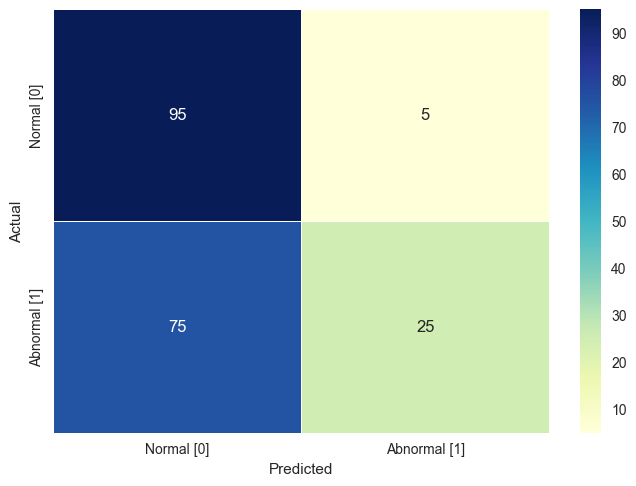

In [195]:
confusionMatrix(predictions_ads[0]['Anomaly'])

accuracy:  0.59
recall:  0.24
precision:  0.8
f1-score:  0.369


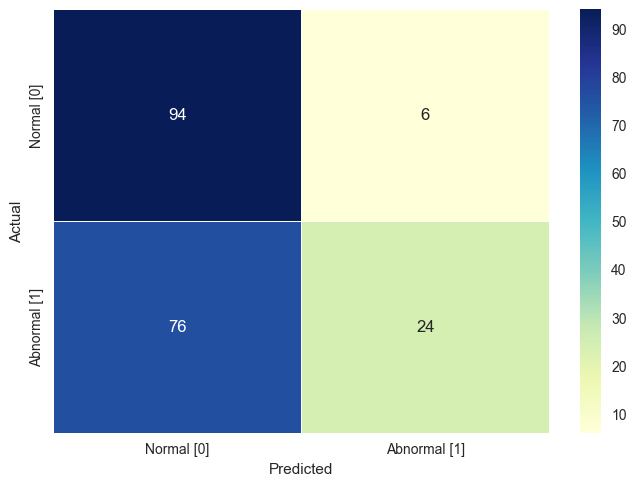

In [196]:
confusionMatrix(predictions_ads[1]['Anomaly'])

accuracy:  0.61
recall:  0.26
precision:  0.867
f1-score:  0.4


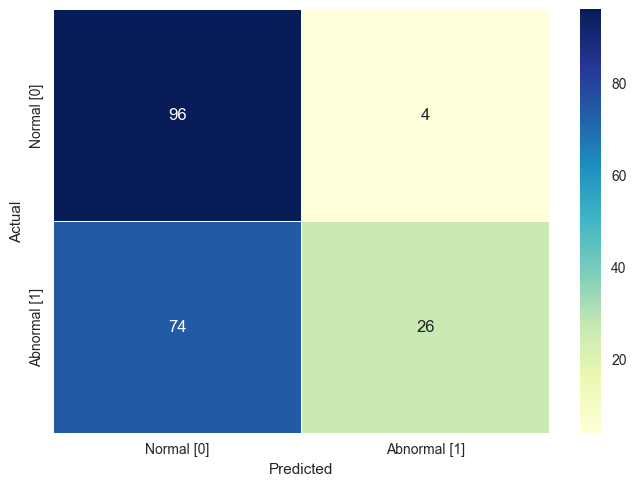

In [197]:
confusionMatrix(predictions_ads[2]['Anomaly'])

accuracy:  0.61
recall:  0.27
precision:  0.844
f1-score:  0.409


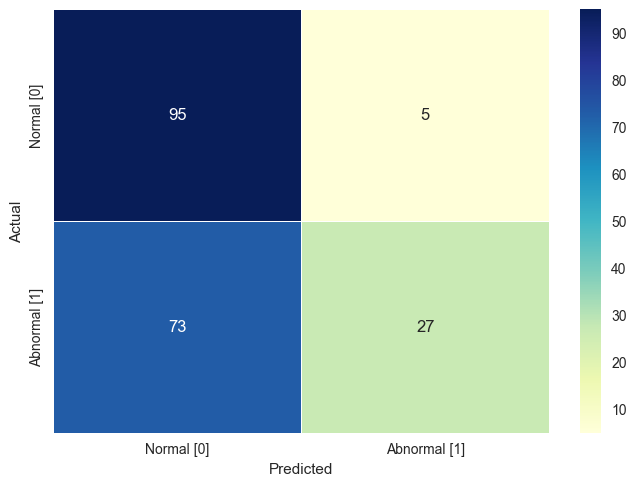

In [198]:
confusionMatrix(predictions_ads[3]['Anomaly'])

accuracy:  0.605
recall:  0.27
precision:  0.818
f1-score:  0.406


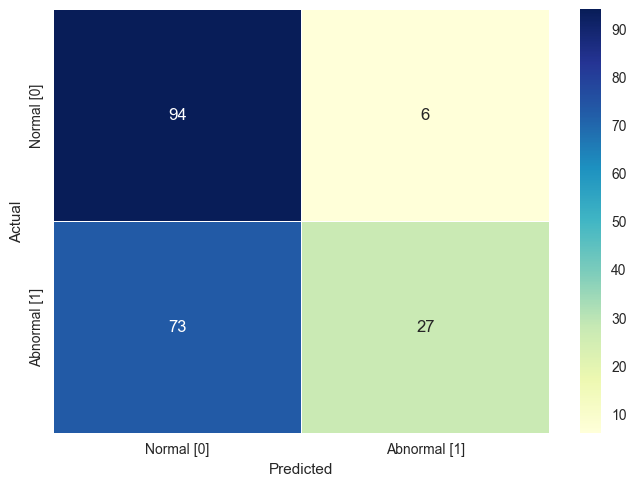

In [199]:
confusionMatrix(predictions_ads[4]['Anomaly'])

In [201]:
test_data['prediction'] = 1
normal = test_data[test_data['prediction_label']>=0.52]
normal = normal[normal['prediction_label']<=0.53]
normal['prediction'] =0
test_data = test_data.drop(normal.index)
test_data = pd.concat([test_data, normal])
test_data

,Y_Class,Y_Quality,LINE,PRODUCT_CODE,X_1,X_2,X_4,X_5,X_7,X_8,...,X_3319,X_3320,X_3321,X_3322,X_3323,X_3324,X_3325,X_3326,prediction_label,prediction
341,0,0.528094,0,1,0.0,1.4,0.0,1.0,-0.833333,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000,0.000000,0.530057,1
96,0,0.528344,1,1,0.0,-1.2,0.0,0.0,0.166667,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000,0.000000,0.531374,1
176,0,0.527516,0,1,0.0,1.4,0.0,0.0,-0.833333,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000,0.000000,0.530024,1
786,0,0.531052,0,1,0.0,0.8,0.0,1.0,-0.833333,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000,0.000000,0.531975,1
753,0,0.533444,0,1,-1.0,1.4,0.0,0.0,-0.833333,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000,0.000000,0.531424,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,1,0.525035,0,1,0.0,1.0,0.0,1.0,-0.833333,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000,0.000000,0.528789,0
403,1,0.536113,0,1,-1.0,0.4,0.0,1.0,-0.833333,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000,0.000000,0.529904,0
354,1,0.524587,1,1,-1.0,0.0,0.0,0.0,0.500000,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000,0.000000,0.526062,0
66,1,0.520868,1,1,1.0,0.2,0.0,0.0,0.500000,0.0,...,0.189544,0.000032,0.000667,0.00004,0.000002,0.000003,0.187,0.000029,0.527136,0


accuracy:  0.575
recall:  0.68
precision:  0.562
f1-score:  0.615


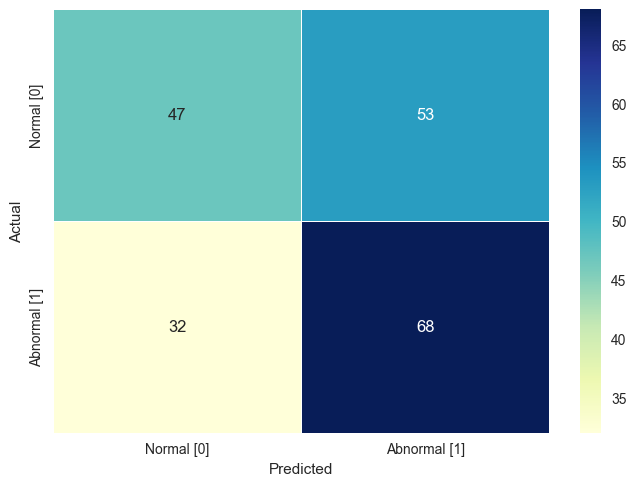

In [202]:
def confusionMatrix(test_pred):
    test_y = test_data['Y_Class']
    con_mat = confusion_matrix(test_y, test_pred)
    sns.heatmap(pd.DataFrame(con_mat, columns = ['Predicted', 'Actual']),
            xticklabels=['Normal [0]', 'Abnormal [1]'], 
            yticklabels=['Normal [0]', 'Abnormal [1]'], 
            annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    print("accuracy: ", accuracy_score(test_y, test_pred))
    print("recall: ", round(recall_score(test_y, test_pred),3))
    print("precision: ", round(precision_score(test_y, test_pred),3))
    print("f1-score: ", round(f1_score(test_y, test_pred),3))
confusionMatrix(test_data['prediction'])

# 6. Plotting

In [ ]:
plot_model(best_model, plot='residuals')

In [ ]:
evaluate_model(best_model)

In [ ]:
interpret_model(total_models[CHECK], plot='summary')

In [ ]:
def graph(pred, true) :
    plt.figure(figsize=(16, 9))
    plt.plot(true, label = 'actual')
    plt.plot(pred, label = 'prediction')
    plt.legend()
    plt.show()

true_y = total_predictions[CHECK]['Y_Quality'].to_numpy()
pred_y = total_predictions[CHECK]['prediction_label'].to_numpy()
graph(pred_y, true_y)